In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import os


import json
import numpy as np

In [8]:
import warnings

# Ignore pandas warnings related to setting values on a copy of a slice from a DataFrame
warnings.filterwarnings("ignore")

def plot_api_policy_throughput(out_folder, csv_files, extra_title=[], category_order=['D','S', 'P', 'H'], model_name="EleutherAI/gpt-j-6b"):
    # Initialize subplots
    fig, axes = plt.subplots(4, 2, figsize=(15, 15))

    # Flatten axes for easy iteration
    axes = axes.flatten()
    # Loop through each CSV file
    for i, csv_file in enumerate(csv_files):
        # Load CSV into a DataFrame
        full_path = os.path.join(out_folder, csv_file)
        df = pd.read_csv(full_path)
        # Filter out non model_name rows
        df = df[df['Model'] == model_name]

        # Group by API Policy and calculate mean throughput
        df['Api Policy'] = pd.Categorical(df['Api Policy'], categories=category_order, ordered=True)
        throughput_data = df.groupby('Api Policy')['Total Throughput'].max()
        # Plot bar chart for each API Policy
        # Find the API Policy with the highest throughput
        max_throughput_policy = throughput_data.idxmax()
        speedup_data = throughput_data / throughput_data[category_order[0]]
        # Plot bar chart for each API Policy, highlight the one with the highest throughput
        bars = throughput_data.plot(kind='bar', ax=axes[i], color=['skyblue' if policy != max_throughput_policy else 'orange' for policy in throughput_data.index])
        title = f'{csv_file.split("_")[0].capitalize()} Experiment'
        if len(extra_title) > 0:
            title += f' - {extra_title[i]}'
        title += f' - {model_name}'
        axes[i].set_title(title, pad=50, y=1)
        axes[i].set_xlabel('API Policy')
        axes[i].set_ylabel('Throughput(Tokens/second)')
        for bar, label, speedup in zip(bars.patches, throughput_data.values, speedup_data.values):
            axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{label:.2f}\nSpeedup: {speedup:.2f}', ha='center', va='bottom')

    [fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]
    

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

def plot_api_policy_throughput_combined(out_folder, csv_files, model_names=["EleutherAI/gpt-j-6b", "lmsys/vicuna-13b-v1.3"], extra_title=[], category_order=['D', 'S', 'P', 'H', 'W']):
    # Initialize subplots
    fig, axes = plt.subplots(4, 2, figsize=(15, 15))

    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    # Loop through each CSV file
    for i, csv_file in enumerate(csv_files):
        # Load CSV into a DataFrame
        full_path = os.path.join(out_folder, csv_file)
        df = pd.read_csv(full_path)

        # Filter rows for specified model names
        df = df[df['Model'].isin(model_names)]

        # Group by API Policy and calculate mean throughput
        df['Api Policy'] = pd.Categorical(df['Api Policy'], categories=category_order, ordered=True)
        throughput_data = df.pivot_table(index='Api Policy', columns='Model', values='Total Throughput', aggfunc='mean')
        
        speedup_data = throughput_data[model_names].div(throughput_data[model_names].loc[category_order[0]])
        # print(csv_file, throughput_data, speedup_data)
        # Plot bar chart for each API Policy with two bars for each model
        bars = throughput_data.plot(kind='bar', ax=axes[i], color=['skyblue', 'orange'])

        title = f'{csv_file.split("_")[0].capitalize()} Experiment'
        if len(extra_title) > 0:
            title += f' - {extra_title[i]}'
        axes[i].set_title(title, pad=50, y=1)
        axes[i].set_xlabel('API Policy')
        axes[i].set_ylabel('Throughput(Tokens/second)')
        axes[i].legend_.remove()
        # Add legend
        # axes[i].legend(title="Model", loc='upper right')
        # Concat all data into one array for throughput_data.T.values
        throughput_data_lst = throughput_data.T.values.flatten()
        speedup_data_lst = speedup_data.T.values.flatten()
        max_values = throughput_data.max(axis=0).tolist()

        for bar, label, speedup in zip(bars.patches, throughput_data_lst, speedup_data_lst):
            axes[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{label:.3f}\nSpeedup: {speedup:.3f}', ha='center', va='bottom')

        max_height_bars = [bar for bar in bars.patches if bar.get_height() in max_values]
        for bar in max_height_bars:
            bar.set_color('lightgreen')

    [fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Calculate the PDF
def calculate_pdf(data):
    unique_values, counts = np.unique(data, return_counts=True)
    pdf = counts / len(data)
    return unique_values, pdf

# Calculate the CDF
def calculate_cdf(data):
    unique_values, counts = np.unique(data, return_counts=True)
    cdf = np.cumsum(counts) / len(data)
    return unique_values, cdf

# Plot the PDF
def plot_pdf(unique_values, pdf):
    plt.bar(unique_values, pdf, align='center', alpha=0.5)
    plt.xlabel('Values')
    plt.ylabel('PDF')
    plt.title('Probability Density Function (PDF)')
    plt.show()

# Plot the CDF
def plot_cdf(unique_values, cdf):
    plt.step(unique_values, cdf, where='post')
    plt.xlabel('Values')
    plt.ylabel('CDF')
    plt.title('Cumulative Distribution Function (CDF)')
    plt.show()


# Calculate the CDF for both data sets
def calculate_cdf(data):
    unique_values, counts = np.unique(data, return_counts=True)
    cdf = np.cumsum(counts) / len(data)
    return unique_values, cdf


# Plot CDF of execution time, throughput, and latency for each experiment file
def plot_cdf_of_exec_times_calls(out_folder, json_files, extra_title=[]):
    # Initialize subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    # Flatten axes for easy iteration
    axes = axes.flatten()

    # Loop through each CSV file
    for i, csv_file in enumerate(json_files):
        # Load CSV into a DataFrame
        full_path = os.path.join(out_folder, csv_file)
        with open(full_path, "r") as f:
            data = json.load(f)
            exec_times = []
            num_calls = []
            max_context_len = []
            for request_id,requests in data.items():
                request_exec_times = []
                num_calls.append(len(requests))
                for request in requests:
                    request_exec_times.append(max(0, request["api_exec_time"]))        
                # TODO get tokenizer amount
                exec_times.append(np.mean(request_exec_times))
            unique_values_gkml, cdf_gkml = calculate_cdf(exec_times)
            # Plot the CDF for both data sets
            axes[i].step(unique_values_gkml, cdf_gkml, label='GKML CDF', where='post', linestyle='-', marker='o', markersize=5, )
            axes[i].set_xlabel('Exec Time(s)')
            axes[i].set_ylabel('CDF')
            title = f'{csv_file.split("_")[0].capitalize()} Experiment'
            if len(extra_title) > 0:
                title += f' - {extra_title[i]}'
            axes[i].set_title('Cumulative Distribution Function of execution time(CDF)', pad=20, y=1.1)
    [fig.delaxes(ax) for ax in axes.flatten() if not ax.has_data()]

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


    
def plot_cdf_of_props(out_folder, json_files, extra_title=[], verbose=False):
    # Initialize a figure with two subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 6))

    # Define color-blind-friendly colors
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    mean_exec_times = []
    mean_num_calls = []
    max_context_lens = []
    mean_api_return_lens = []

    # Loop through each CSV file
    for i, csv_file in enumerate(json_files):
        # Load JSON into a DataFrame
        full_path = os.path.join(out_folder, csv_file)
        with open(full_path, "r") as f:
            data = json.load(f)
            exec_times = []
            num_calls = []
            max_context_len = []
            api_return_lens = []
            for request_id, requests in data.items():
                request_exec_times = []
                prompt_size = []
                api_return_len = []
                num_calls.append(len(requests))
                for request in requests:
                    request_exec_times.append(max(0, request["api_exec_time"]))      
                    prompt_size.append(request.get("prompt_size", 0))  
                    api_return_size = request.get("api_ret_len", request.get("api_return_len", 0))
                    if max(0, request["api_exec_time"]) == 0:
                        api_return_size = 0
                    api_return_len.append(api_return_size)
                
                exec_times.append(np.mean(request_exec_times))
                prompt_size_total = min(np.sum(prompt_size), 2048)
                max_context_len.append(prompt_size_total) # Clip to 2048
                api_return_lens.append(np.mean(api_return_len))
            
            unique_values_gkml_exec, cdf_gkml_exec = calculate_cdf(exec_times)
            unique_values_gkml_calls, cdf_gkml_calls = calculate_cdf(num_calls)
            unique_values_context_len, cdf_gkml_context_len = calculate_cdf(max_context_len)
            unique_values_api_return_len, cdf_gkml_api_return_len = calculate_cdf(api_return_lens)

            # Plot the CDF for execution times on the first subplot
            mean_exec_time = np.mean(exec_times)
            if verbose:
                print(csv_file, "Mean exec time", mean_exec_time)
            mean_exec_times.append(mean_exec_time)
            ax1.step(
                unique_values_gkml_exec,
                cdf_gkml_exec,
                label=f'{csv_file.split("_")[0].capitalize()} Experiment',
                where='post',
                linestyle='-',
                marker='o',
                markersize=5,
                color=colors[i % len(colors)],
            )

            # Plot the CDF for num calls on the second subplot
            mean_num_call = np.mean(num_calls)
            if verbose:
                print(csv_file, "Mean num calls", mean_num_call)
            mean_num_calls.append(mean_num_call)
            ax2.step(
                unique_values_gkml_calls,
                cdf_gkml_calls,
                label=f'{csv_file.split("_")[0].capitalize()} Experiment',
                where='post',
                linestyle='-',
                marker='o',
                markersize=5,
                color=colors[i % len(colors)],
            )

            mean_max_context_len = np.mean(max_context_len)
            if verbose:
                print(csv_file, "Mean max context len", mean_max_context_len)
            max_context_lens.append(mean_max_context_len)
            # Plot the Api Return Length as well
            if verbose:
                print(csv_file, "Mean api return len", np.mean(api_return_lens))
            mean_api_return_lens.append(np.median(api_return_lens))

            # ax4.step(
            #     unique_values_api_return_len,
            #     cdf_gkml_api_return_len,
            #     label=f'{csv_file.split("_")[0].capitalize()} Experiment',
            #     where='post',
            #     linestyle='-',
            #     marker='o',
            #     markersize=5,
            #     color=colors[i % len(colors)],
            # )
    


    # Create a legend box for mean values
    legend_text = [f'{csv_file.split("_")[0].capitalize()}: {mean:.2f}' for csv_file, mean in zip(json_files, mean_exec_times)]
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), labels=legend_text)

    legend_text = [f'{csv_file.split("_")[0].capitalize()}: {mean:.2f}' for csv_file, mean in zip(json_files, mean_num_calls)]
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), labels=legend_text)

    titles = [f'{csv_file.split("_")[0].capitalize()}' for csv_file, mean in zip(json_files, max_context_lens)]
    ax3.bar(
        range(len(max_context_lens)),
        max_context_lens,
        color=colors[0]
    )
    ax3.set_xticks(range(len(max_context_lens)), titles, rotation=45, ha='right')

    titles = [f'{csv_file.split("_")[0].capitalize()}' for csv_file, mean in zip(json_files, mean_api_return_lens)]
    ax4.bar(
        range(len(mean_api_return_lens)),
        mean_api_return_lens,
        color=colors[0]
    )
    ax4.set_xticks(range(len(mean_api_return_lens)), titles, rotation=45, ha='right')

    # legend_text = [f'{csv_file.split("_")[0].capitalize()}: {mean:.2f}' for csv_file, mean in zip(json_files, api_return_lens)]
    # ax4.legend(loc='upper left', bbox_to_anchor=(1, 1), labels=legend_text)

    ax1.set_xlabel('Exec Time(s)')
    ax1.set_ylabel('CDF')
    ax1.set_title(f'CDF of {extra_title[0]} Execution Time')

    ax2.set_xlabel('Num Calls')
    ax2.set_ylabel('CDF')
    ax2.set_title(f'CDF of {extra_title[0]} Num Calls')

    ax3.set_xlabel('Max Context Len')
    ax3.set_ylabel('Context Len')
    ax3.set_title(f'{extra_title[0]} Context Len')

    ax4.set_xlabel('Api Return Len')
    ax4.set_ylabel('CDF')
    ax4.set_title(f'CDF of {extra_title[0]} Api Return Len')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()



In [9]:
workloads_out = {
    "slow": ["alfworld_trace_out.csv", "gkml_out.csv", "hotpot_qa_out.csv"],
    "diffusion": ["diffusion/diffusion_10_out.csv"],
    "tts": ["tts/tts_10_out.csv"],
    "web_search": ["web_search/web_search_10_out.csv"],
    "chat": [ "chat/chat_bot_3_out.csv", "chat/chat_bot_5_out.csv", "chat/chat_bot_10_out.csv", "chat/chat_bot_15_out.csv"],
}

workload_exp = {
    "slow": [out.replace("csv", "json").replace("_out", "") for out in workloads_out["slow"]],
    "diffusion": [out.replace("csv", "json").replace("_out", "") for out in workloads_out["diffusion"]],
    "tts": [out.replace("csv", "json").replace("_out", "") for out in workloads_out["tts"]],
    "web_search": [out.replace("csv", "json").replace("_out", "") for out in workloads_out["web_search"]],
    "chat": [out.replace("csv", "json").replace("_out", "") + "_filtered.json" for out in workloads_out["chat"]],
}

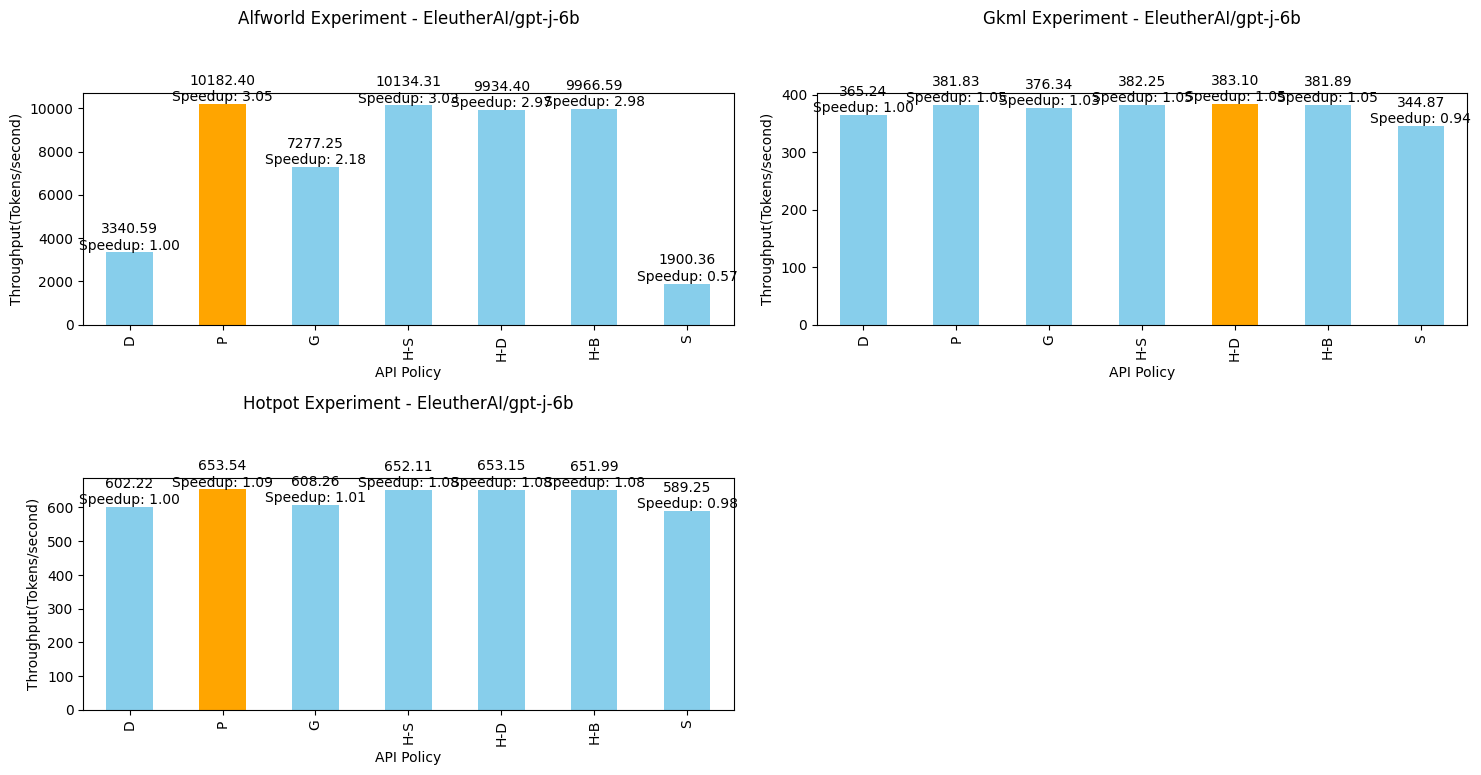

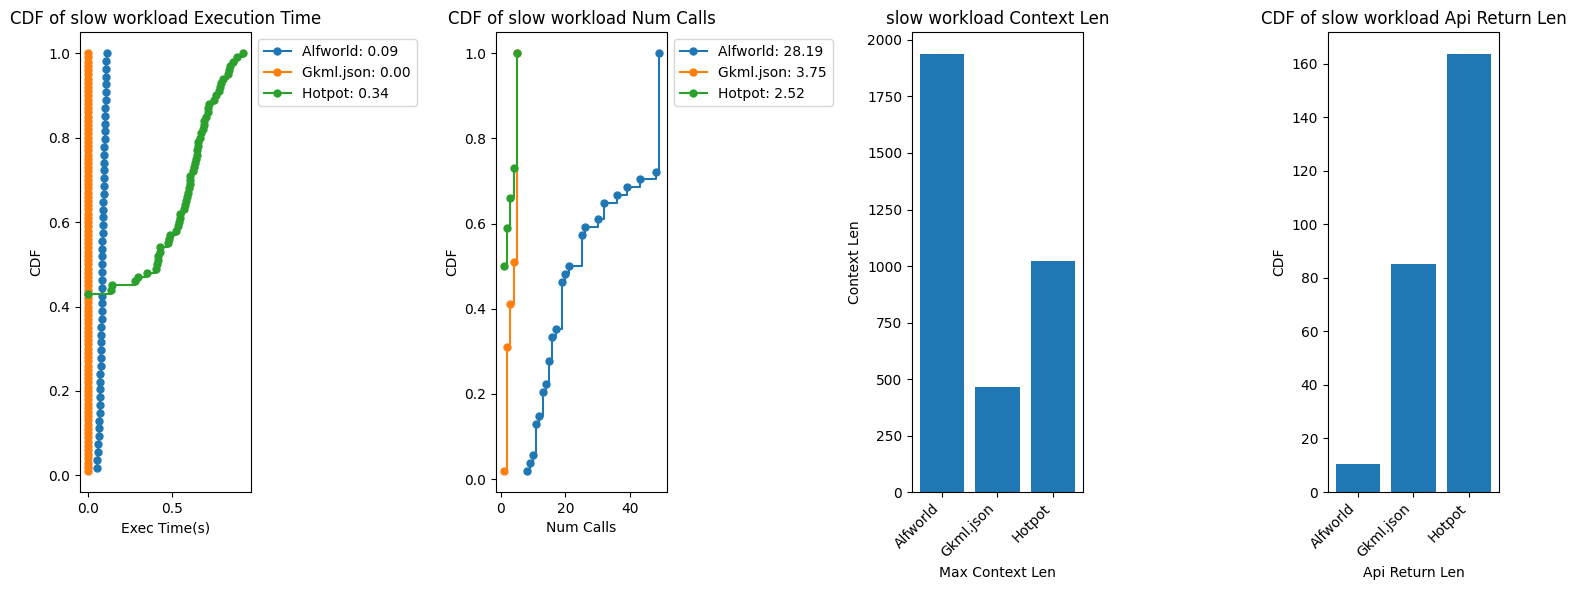

In [7]:
# plot_api_policy_throughput("../exp_logs_version7", workloads_out["slow"])
# plot_api_policy_throughput("../exp_logs_version7", workloads_out["slow"], model_name="lmsys/vicuna-13b-v1.3")

plot_api_policy_throughput("../exp_logs_version10", workloads_out["slow"], category_order=['D', 'P', 'G', 'H-S', 'H-D', 'H-B', 'S'])
plot_cdf_of_props("../exp_version9", workload_exp["slow"], extra_title=["slow workload"])

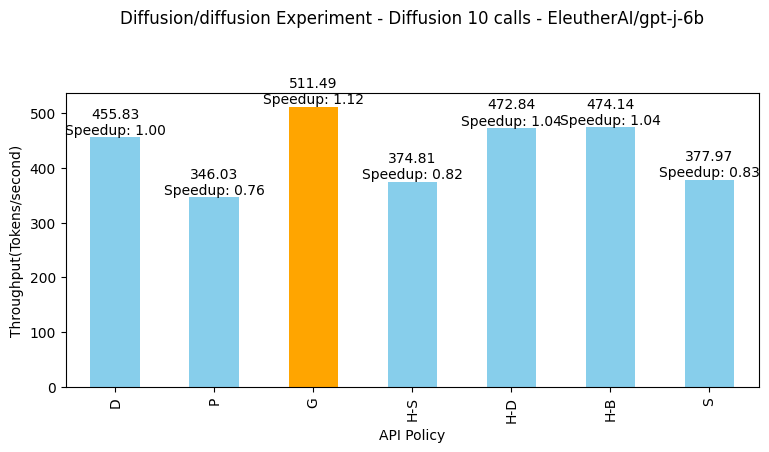

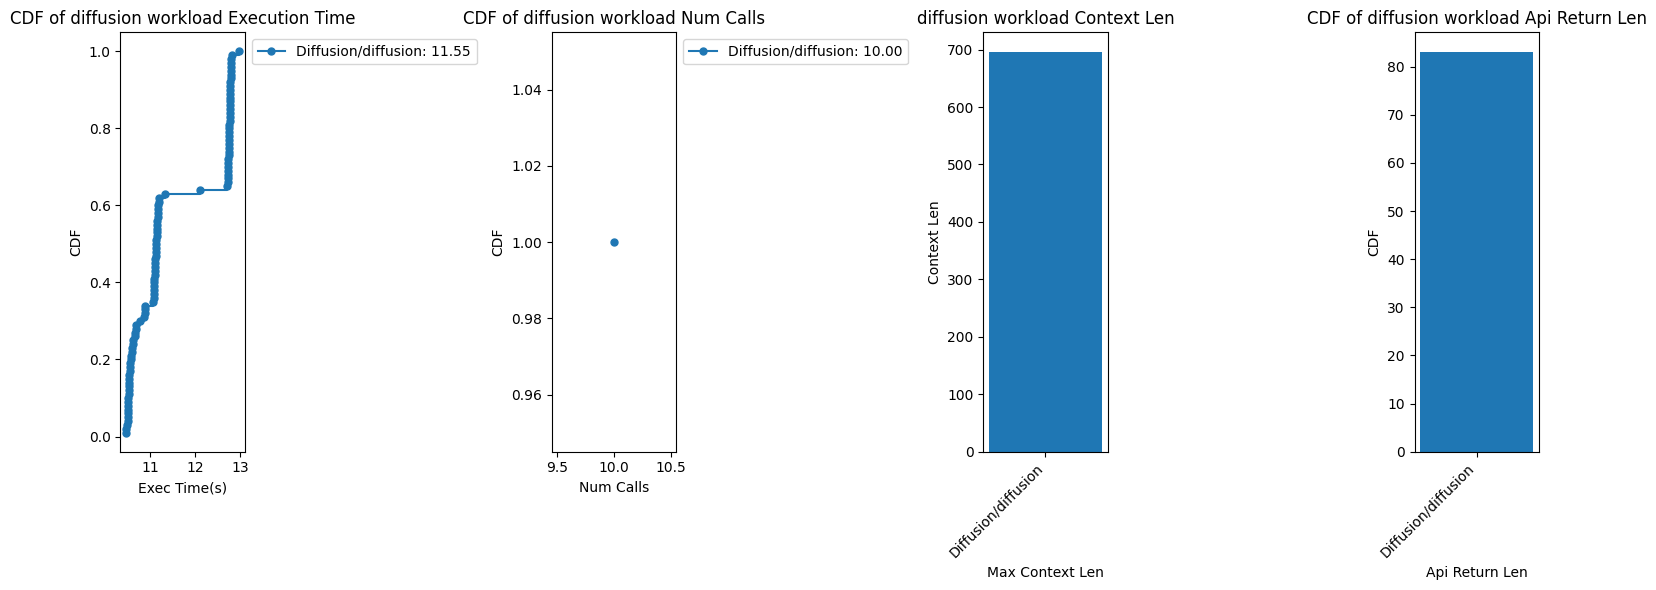

In [6]:
# plot_api_policy_throughput("../exp_logs_version7", workloads_out["diffusion"], extra_title=["Diffusion 1 call", "Diffusion 3 calls", "Diffusion 5 calls", "Diffusion 10 calls"])
plot_api_policy_throughput("../exp_logs_version10", workloads_out["diffusion"], extra_title=["Diffusion 10 calls"], category_order=['D', 'P', 'G', 'H-S', 'H-D', 'H-B', 'S'])
# plot_api_policy_throughput_combined("../exp_logs_version9", workloads_out["diffusion"], extra_title=["Diffusion 1 call", "Diffusion 3 calls", "Diffusion 5 calls", "Diffusion 10 calls"])
plot_cdf_of_props("../exp_version9", workload_exp["diffusion"], extra_title=["diffusion workload"])

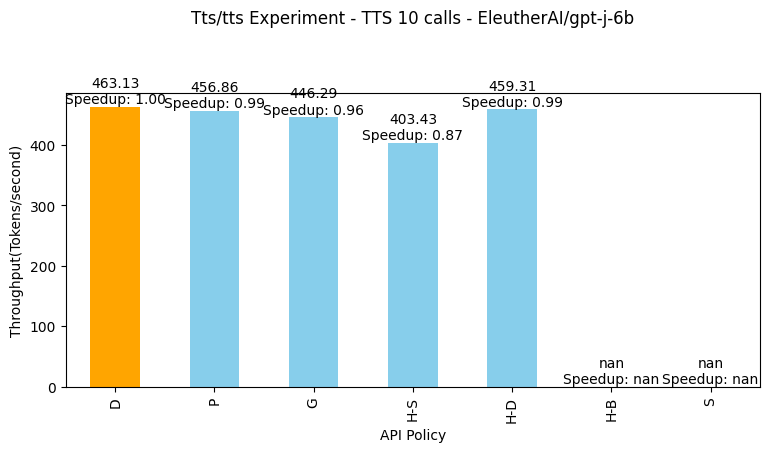

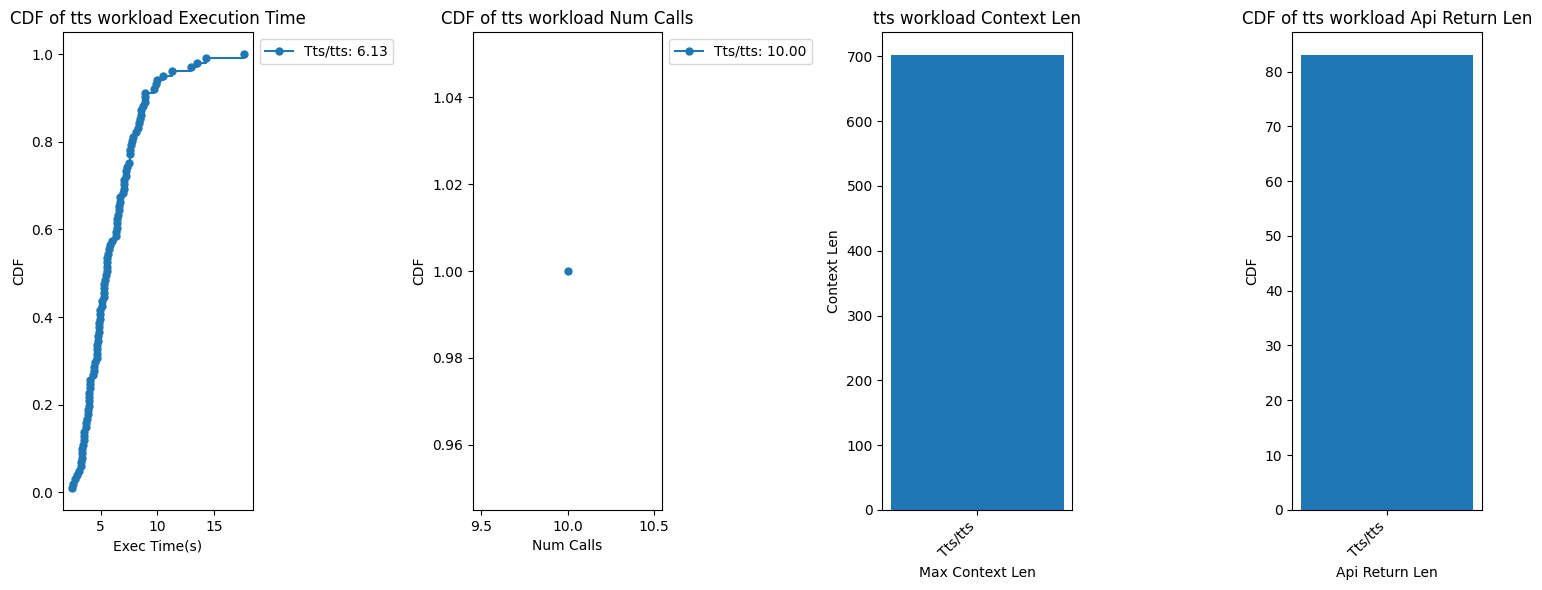

In [10]:
# plot_api_policy_throughput("../exp_logs_version7", workloads_out["tts"], extra_title=["TTS 1 call", "TTS 3 calls", "TTS 5 calls", "TTS 10 calls"])
plot_api_policy_throughput("../exp_logs_version10", workloads_out["tts"], extra_title=["TTS 10 calls"], category_order=['D', 'P', 'G', 'H-S', 'H-D', 'H-B', 'S'])
# plot_api_policy_throughput_combined("../exp_logs_version7", workloads_out["tts"], extra_title=["TTS 1 call", "TTS 3 calls", "TTS 5 calls", "TTS 10 calls"])
plot_cdf_of_props("../exp_version9", workload_exp["tts"], extra_title=["tts workload"])

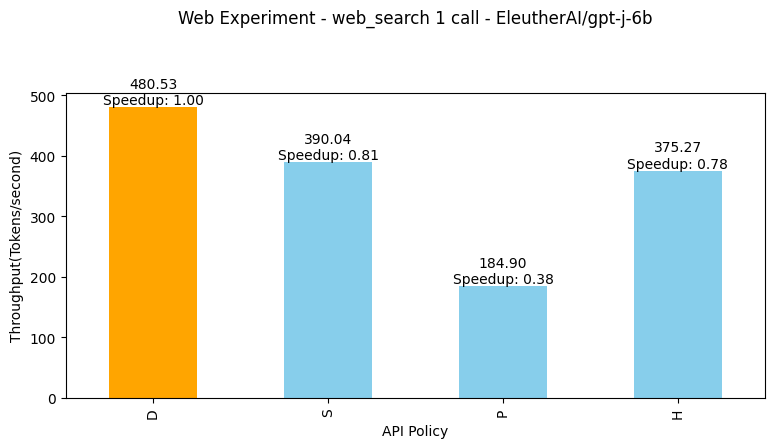

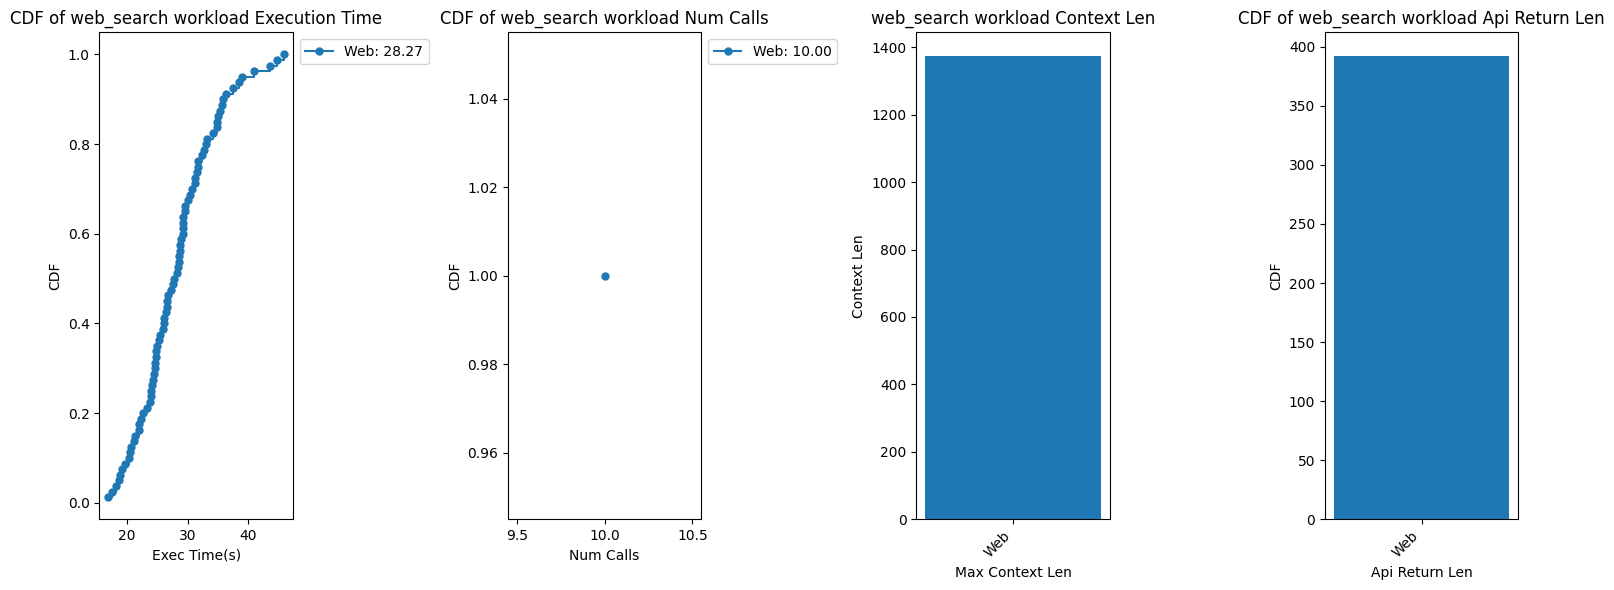

In [15]:
plot_api_policy_throughput("../exp_logs_version9", workloads_out["web_search"], extra_title=["web_search 1 call", "web_search 3 calls", "web_search 5 calls", "web_search 10 calls"])
# plot_api_policy_throughput_combined("../exp_logs_version9", workloads_out["web_search"], extra_title=["web_search 1 call", "web_search 3 calls", "web_search 5 calls", "web_search 10 calls"])
plot_cdf_of_props("../exp_version9", workload_exp["web_search"], extra_title=["web_search workload"])

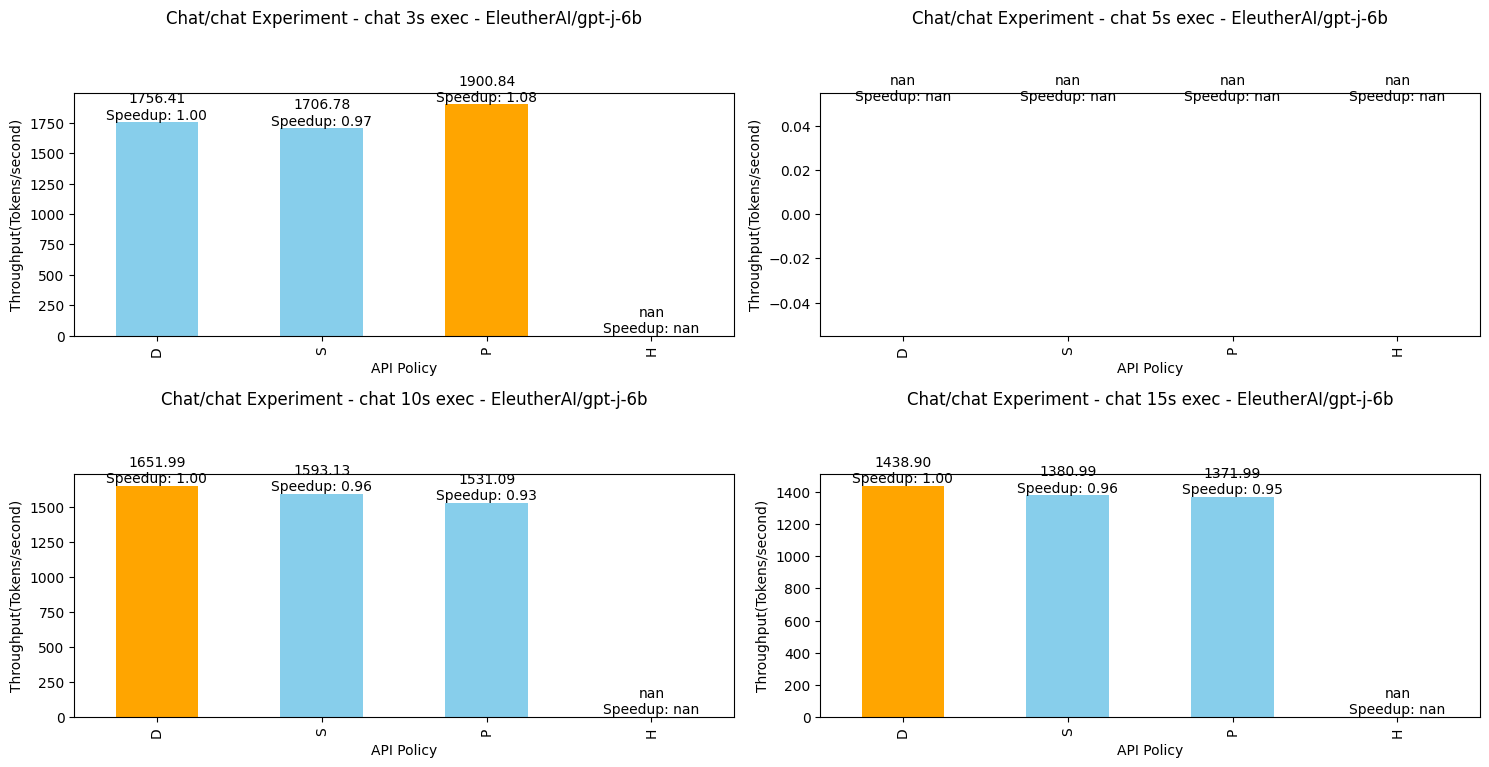

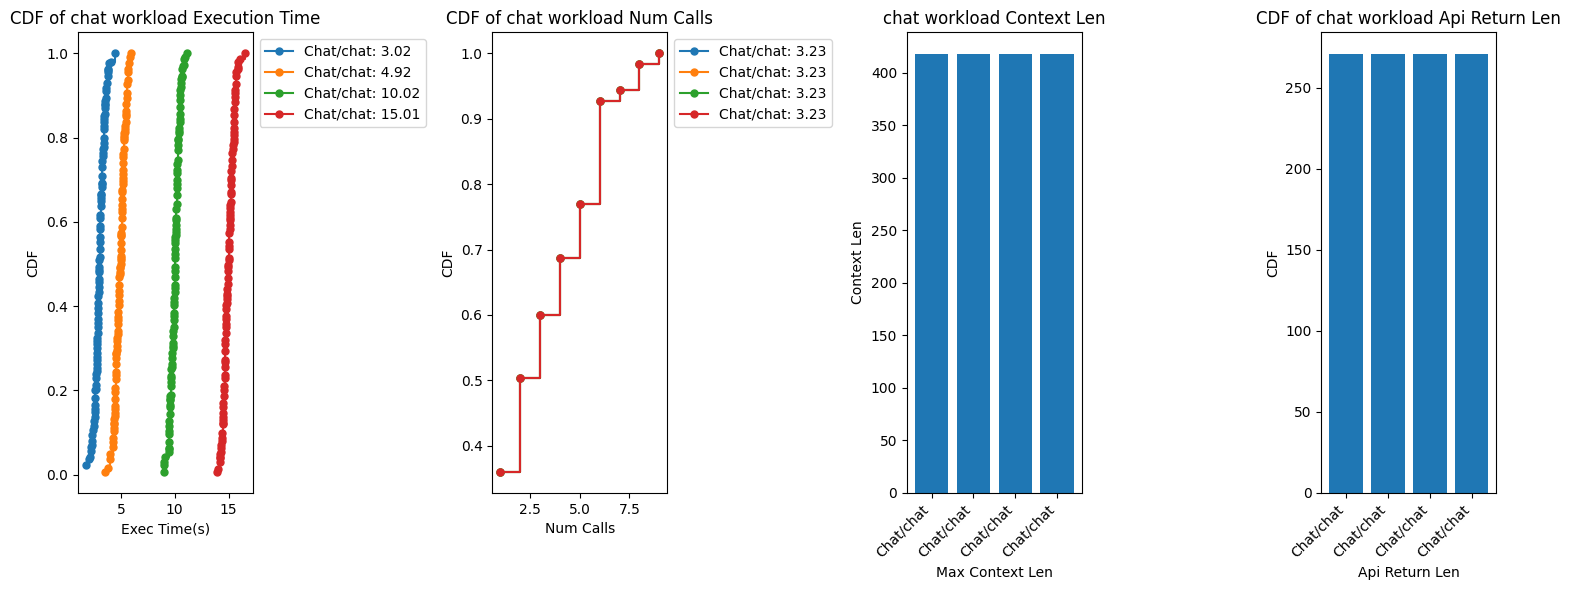

In [10]:
plot_api_policy_throughput("../exp_logs_version10", workloads_out["chat"], extra_title=[ "chat 3s exec", "chat 5s exec","chat 10s exec", "chat 15s exec"])
# plot_api_policy_throughput_combined("../exp_logs_version7", workloads_out["chat"], extra_title=[ "chat 3s exec", "chat 5s exec", "chat 6s exec", "chat 10s exec", "chat 15s exec", "chat 30s exec"])
plot_cdf_of_props("../exp_version7", workload_exp["chat"], extra_title=["chat workload"])

In [9]:
# chat_version3 = ["chat/chat_bot_3_out.csv", "chat/chat_bot_5_out.csv",  "chat/chat_bot_15_out.csv", "chat/chat_bot_30_out.csv"]
# chat_exp_version3 = [out.replace("csv", "json").replace("_out", "") for out in chat_version3]

# plot_api_policy_throughput("../exp_logs_version3",chat_version3, extra_title=["chat 0s exec", "chat 10s exec", "chat 17s exec", "chat 30s exec"], category_order=['H', 'W'])
# plot_cdf_of_props("../exp_version3", chat_exp_version3, extra_title=["chat workload"])

In [68]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Create some sample data
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)

# # Create a figure and a grid of subplots
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# # Plot the first graph in the first subplot
# ax[0].plot(x, y1, label='Sin(x)', color='blue')
# ax[0].set_title('Graph 1')
# ax[0].legend()

# # Plot the second graph in the second subplot
# ax[1].plot(x, y2, label='Cos(x)', color='orange')
# ax[1].set_title('Graph 2')
# ax[1].legend()

# # Adjust layout to prevent clipping of titles
# plt.tight_layout()

# # Show the plots
# plt.show()